# Basic Imports

In [1]:
from __future__ import print_function, division
import logging
reload(logging)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s.%(msecs).03d %(name)s %(message)s",
    datefmt='%Y-%m-%dT%H:%M:%S'
)

In [2]:
%matplotlib inline

In [3]:
import pandas
import numpy
from matplotlib import pylab
import seaborn

# Import Sequencing Data

Selection data needs to be formatted as a "list of dicts" representing each round of selection. This structure is of the form:

````
{ name : # Name of the selection round.
    {
        "parent" : # Name of parent population, if selection was performed, else None
        "selection_level" : # Protease level, if selection was performend, else None
        "fraction_sampled" : # Optional, fraction of population collected during sort, else None
        "selected" : # Integer counts of # of cells selected in round. Derived from sequence data.
    }
}
````

In [4]:
chymo_fit_data = pandas.read_csv("161005_grocklin_chymo_fit_data", delim_whitespace=True)
chymo_src_data = (
    pandas.read_csv("161003_grocklin_chymo_data", delim_whitespace=True)
    .rename(columns={"chymo%s" % i : "rd%s" % i for i in range(1, 7)}))

#seq_counts & num_selected will be used to infer cell counts during selection
chymo_pop_data = {
    "rd0" : dict(seq_counts = chymo_src_data["rd0"], parent = None,  selection_level=None, num_selected=1.5e6, fraction_sampled = None),
    "rd1" : dict(seq_counts = chymo_src_data["rd1"], parent = "rd0", selection_level=1,    num_selected=1.5e6, fraction_sampled = None),
    "rd2" : dict(seq_counts = chymo_src_data["rd2"], parent = "rd0", selection_level=2,    num_selected=540e3, fraction_sampled = None),
    "rd3" : dict(seq_counts = chymo_src_data["rd3"], parent = "rd2", selection_level=3,    num_selected=640e3, fraction_sampled = .46),
    "rd4" : dict(seq_counts = chymo_src_data["rd4"], parent = "rd2", selection_level=4,    num_selected=52e3,  fraction_sampled = .039),
    "rd5" : dict(seq_counts = chymo_src_data["rd5"], parent = "rd4", selection_level=5,    num_selected=114e3, fraction_sampled = .048),
    "rd6" : dict(seq_counts = chymo_src_data["rd6"], parent = "rd4", selection_level=6,    num_selected=63e3,  fraction_sampled = .026),
}

for k, v in chymo_pop_data.items():
    pfrac = v["seq_counts"].values.astype(float) / v['seq_counts'].sum()
    v["selected"] = numpy.floor(pfrac * v["num_selected"])

# Generate Model and fit MAP

In [18]:
import protease_sequencing_model
reload(protease_sequencing_model)

<module 'protease_sequencing_model' from 'protease_sequencing_model.pyc'>

In [27]:
chymo_model = (
    protease_sequencing_model.FractionalSelectionModel(homogenous_k=True)
    .build_model(chymo_pop_data))

2016-10-20T23:15:00.760 protease_sequencing_model Unused keys in population_data['rd5'] : set(['num_selected', 'fraction_sampled', 'seq_counts'])
2016-10-20T23:15:00.761 protease_sequencing_model Unused keys in population_data['rd4'] : set(['num_selected', 'fraction_sampled', 'seq_counts'])
2016-10-20T23:15:00.762 protease_sequencing_model Unused keys in population_data['rd6'] : set(['num_selected', 'fraction_sampled', 'seq_counts'])
2016-10-20T23:15:00.763 protease_sequencing_model Unused keys in population_data['rd1'] : set(['num_selected', 'fraction_sampled', 'seq_counts'])
2016-10-20T23:15:00.764 protease_sequencing_model Unused keys in population_data['rd0'] : set(['num_selected', 'fraction_sampled', 'seq_counts'])
2016-10-20T23:15:00.765 protease_sequencing_model Unused keys in population_data['rd3'] : set(['num_selected', 'fraction_sampled', 'seq_counts'])
2016-10-20T23:15:00.766 protease_sequencing_model Unused keys in population_data['rd2'] : set(['num_selected', 'fraction_sam

Applied log-transform to sel_k and added transformed sel_k_log_ to model.
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


In [28]:
%%time
default_map = chymo_model.find_MAP()

2016-10-20T23:15:18.237 protease_sequencing_model optimize_params: 12522 members
2016-10-20T23:15:46.966 protease_sequencing_model scan_ec50_outliers: 12522 members
2016-10-20T23:25:28.593 protease_sequencing_model Modified 0.527 outliers. (6598/12522)
2016-10-20T23:25:28.603 protease_sequencing_model optimize_params: 12522 members


CPU times: user 10min 12s, sys: 3.58 s, total: 10min 15s
Wall time: 10min 18s


In [31]:
opt_params = chymo_model.optimize_params()

2016-10-20T23:26:18.925 protease_sequencing_model optimize_params: 12522 members


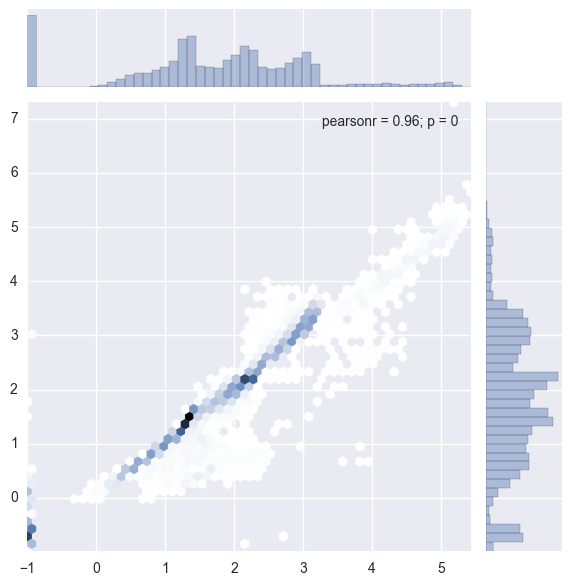

In [52]:
seaborn.jointplot(
    chymo_fit_data["ec50"].values, default_map["sel_ec50"],
    kind="hex", joint_kws=dict(mincnt=1))

# Estimate sample ec50 credible intervals

,name,sequence,rd0,rd1,rd2,rd3,rd4,rd5,rd6
12478,EEHEE_rd3_0846.pdb_PG_hp,GDFTYGHTHAEAPTPTVVLHYANEYLQNEKVPVNVNGTEVKVK,24,3,7,22,0,0,0
5081,EEHEE_rd3_1582.pdb_PG_hp,NNVEAGHYKAQAPTPEKVANFVNEILTKIKGKITVKTGHITFT,39,1,1,0,0,0,0
9823,EEHEE_rd3_1646.pdb,GTVHVGDFTYQAPTPEKAQKLAKIAAKIYGLEVHIEGNEITLK,41,9,4,0,0,0,0
2484,HEEH_rd3_1654.pdb_PG_hp,EPTLESIVNQAQKDTVHRAQAKGINAEIEEPKKLADLAETLVE,41,5,21,59,0,0,0


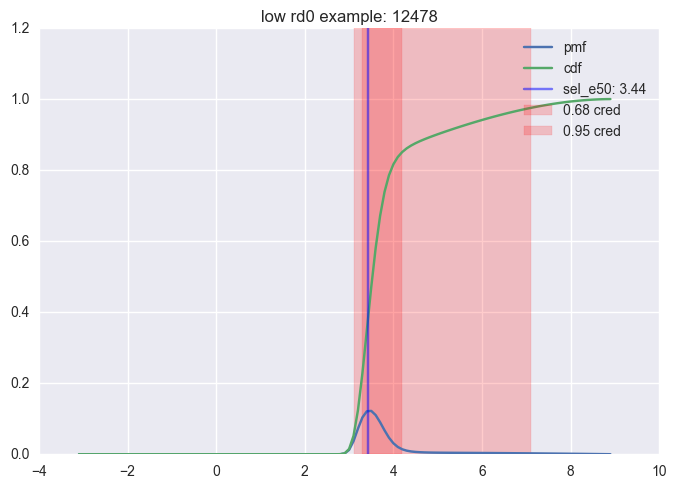

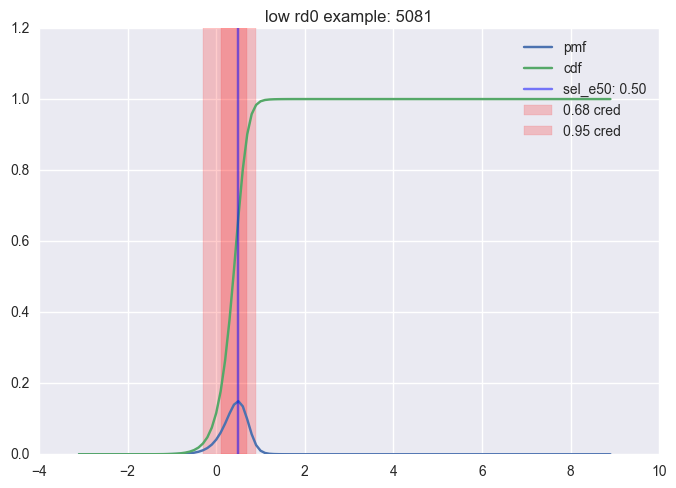

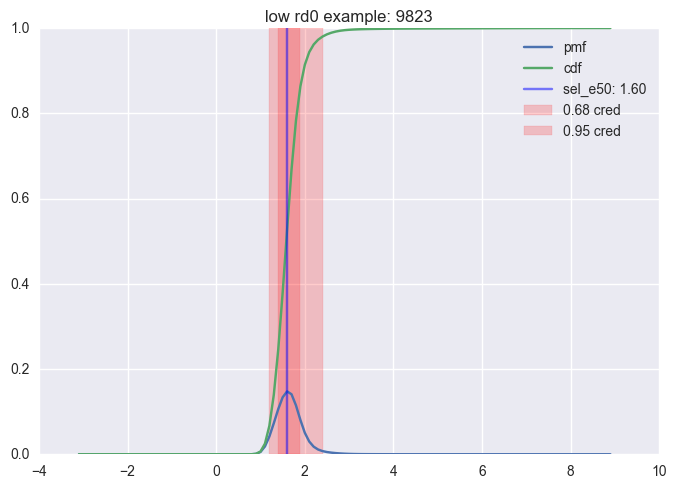

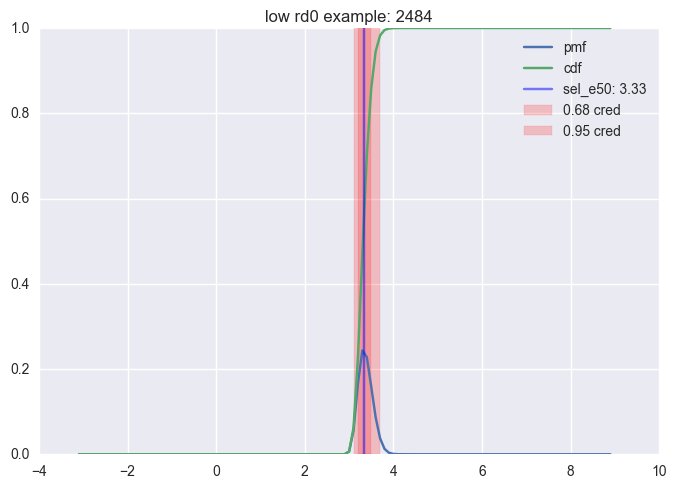

In [53]:
low_count_examples = chymo_src_data.sort_values(by="rd0").query("rd2 != 0 & rd1 != 0", engine="python").head(4)

for i in low_count_examples.index.values:
    pylab.figure()
    chymo_model.plot_cred_summary(chymo_model.estimate_ec50_cred(default_map, i))
    pylab.title("low rd0 example: %i" % i)
    pylab.legend()
    
low_count_examples

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


,name,sequence,rd0,rd1,rd2,rd3,rd4,rd5,rd6
2794,EEHEE_rd3_1407.pdb,STVTVGDKTFKADNPEKAKKLAQKFAKIYNLPVTQHGNKFTVQ,1596,0,0,0,1,0,0
2877,HEEH_rd3_0137.pdb,SSQQKIKRAEWAAEKGKPVTVNGFTVTSPEEAKKLIKYLRKLS,758,40,8,0,0,0,0
5322,EEHEE_rd3_0173.pdb,QTVHVNGTQYKFPSDDAAKKWAKEYANKKGLKVENDGNRITIK,200,68,0,0,0,0,0
2795,HEEH_rd3_1125.pdb,PEDAKKIAKKIKKNNITEVHTNGYTVHADSPELAAKIAYEILA,502,97,133,0,0,0,0
3453,EEHEE_rd3_0942.pdb_PG_hp,KQYTYTGKTVHFPKRSVVNEAAKKLAKKYNATVNAVGTQAKVT,1152,540,532,737,1,0,0
10836,HEEH_0780.pdb,DDRKEKIRQEIEKKTTVTVGGITVTADGSEEAKRRAKEAAERC,338,37,123,316,1548,10191,21410


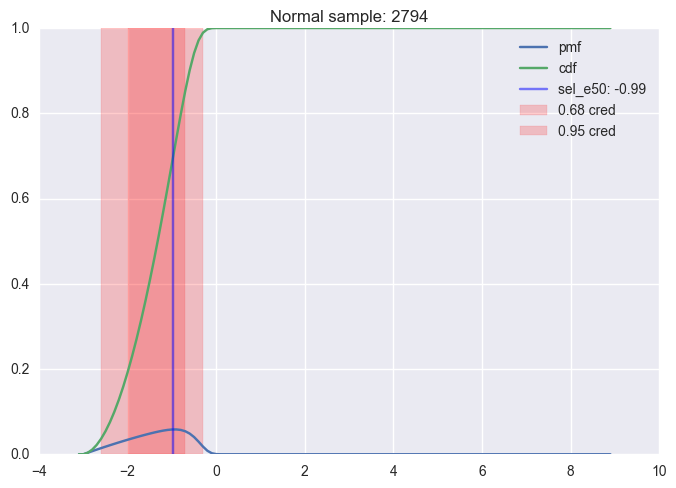

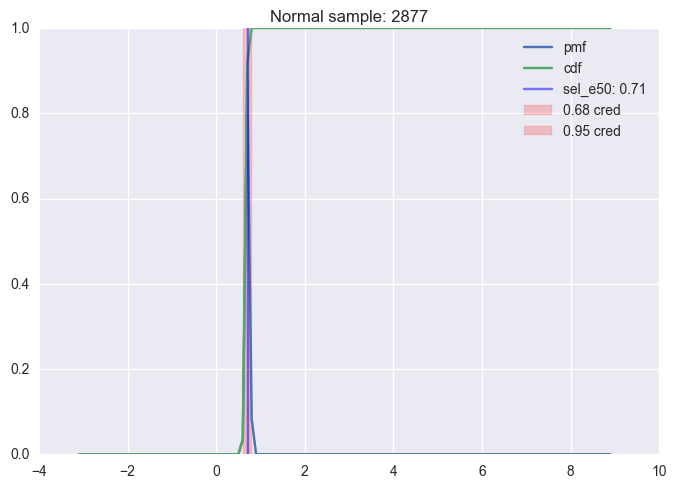

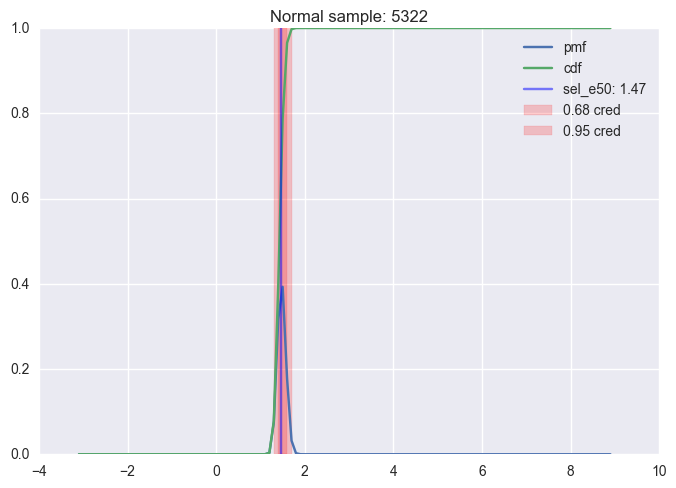

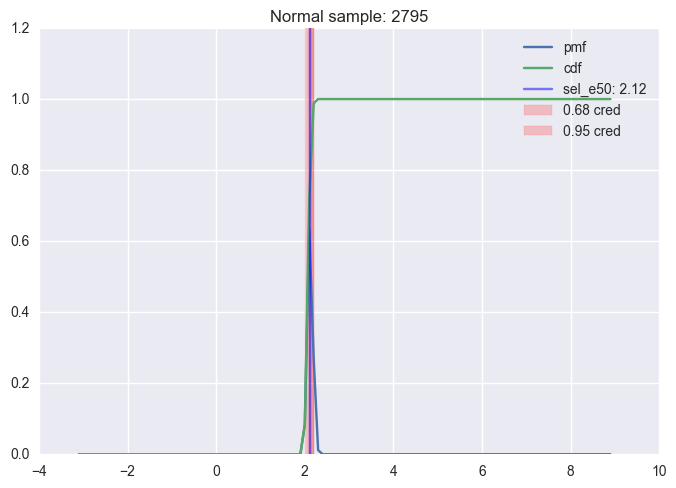

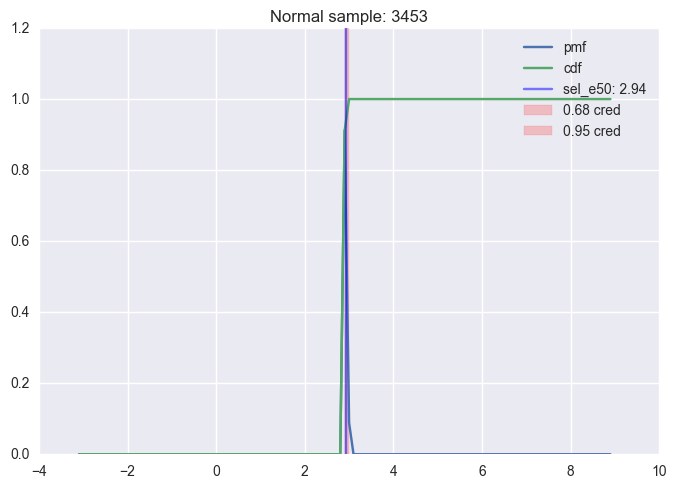

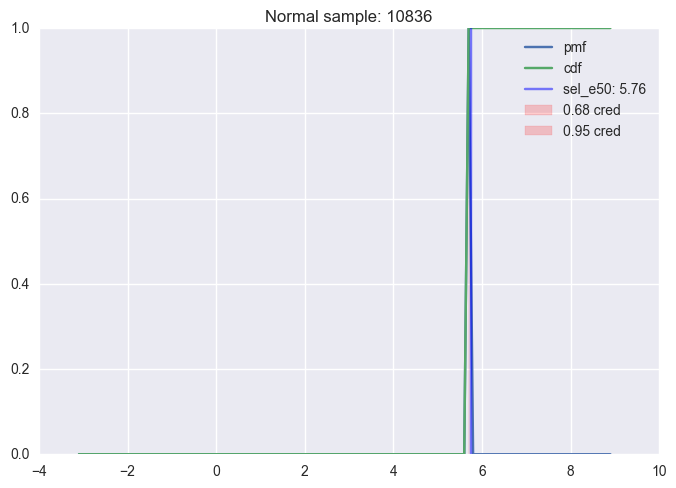

In [54]:
iorder = numpy.argsort(default_map["sel_ec50"])

isamples = iorder[::len(iorder)/5]


for i in isamples:
    pylab.figure()
    pylab.title("Normal sample: %s" % i)
    
    chymo_model.plot_cred_summary(chymo_model.estimate_ec50_cred(default_map, i))
    
    pylab.legend()
chymo_src_data.iloc[isamples]

rd0 > 200 & 0 < rd1 < rd0 * .2 & 0 < rd3 < 10 & 0 < rd4 < 10 & 0 < rd5


,name,sequence,rd0,rd1,rd2,rd3,rd4,rd5,rd6
8349,HEEH_rd3_0146.pdb_buryD,HAEDWAELDAKLNKPIKVQENGVTVTFQPGNKELAQKAYKAVF,1938,355,35,1,1,1,0
9829,EEHEE_rd3_0236.pdb_buryD,TTDHLNGQQYTFDNPEEAEKWAKKVAEEIGGTFEQHGTEYHVK,696,137,0,1,1,2,3


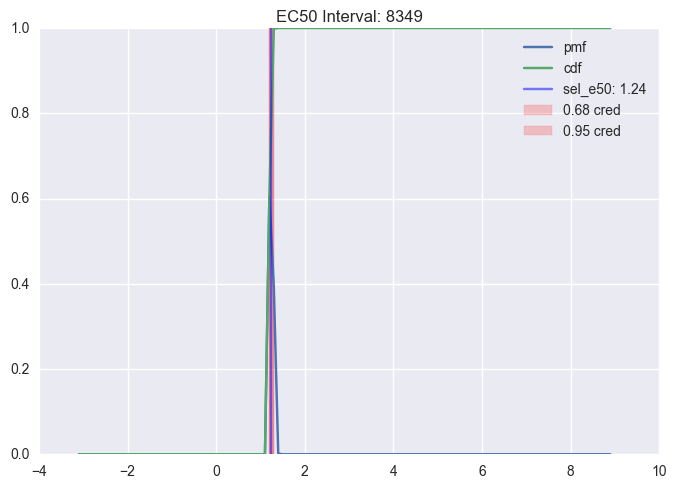

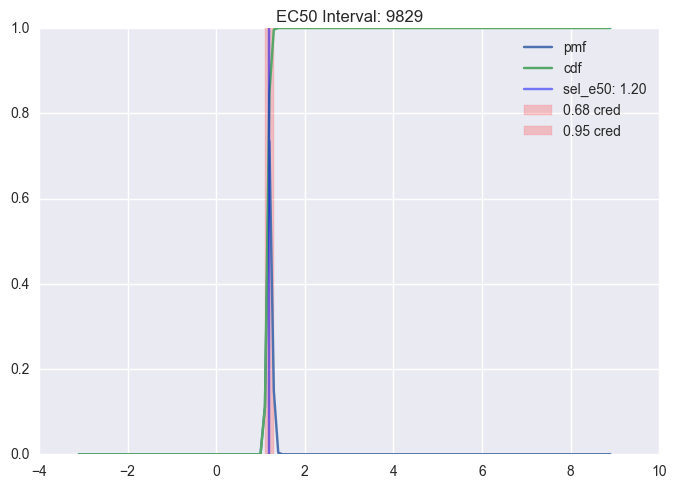

In [55]:
#lc_outlier_query = "rd0 > 200 & 0 < rd1 < 200 & 0 < rd2 < 10 & 0 < rd3 < 10 & 0 < rd4 < 10"
lc_outlier_query = "rd0 > 200 & 0 < rd1 < rd0 * .2 & 0 < rd3 < 10 & 0 < rd4 < 10 & 0 < rd5"
lc_outliers = chymo_src_data.query(lc_outlier_query, engine="python")

print(lc_outlier_query)
for i in lc_outliers.index.values:
    pylab.figure()
    pylab.title("EC50 Interval: %s" % i)
    chymo_model.plot_cred_summary(chymo_model.estimate_ec50_cred(default_map, i))
    
    pylab.legend()
    
lc_outliers

In [56]:
import ipywidgets

name                            HEEH_rd3_1353.pdb_PG_hp
sequence    PPEDIAEAAAKWGTPANLEKNGAQLTVPPGTKKAYQTLLAHIQ
rd0                                                 275
rd1                                                  95
rd2                                                  49
rd3                                                  83
rd4                                                   0
rd5                                                   0
rd6                                                   0
Name: 0, dtype: object


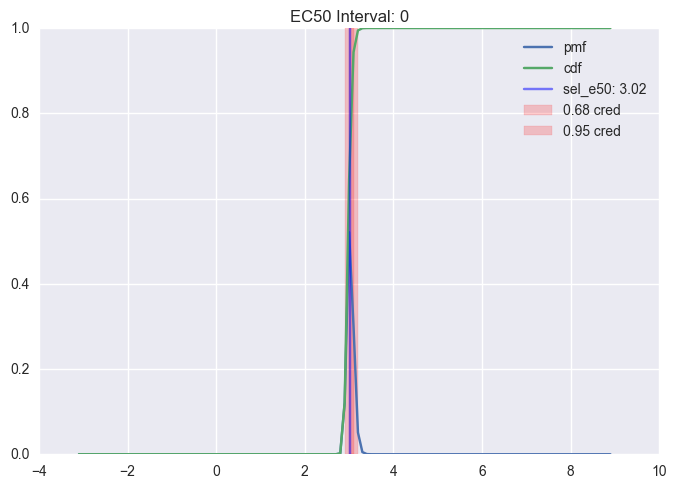

In [57]:
def plot_ec50_interval(i):
    pylab.figure()
    pylab.title("EC50 Interval: %s" % i)
    print(chymo_src_data.ix[i])
    chymo_model.plot_cred_summary(chymo_model.estimate_ec50_cred(default_map, i))
    
    pylab.legend()
    
ipywidgets.interact(plot_ec50_interval, i=ipywidgets.IntText())
pass

# Estimate posterior probability distributions

In [58]:
sel_sum = chymo_model.model_outlier_summary(default_map)

In [59]:
mean_errors = sorted([(k, numpy.nanmean(v["sel_log_likelihood"])) for k, v in sel_sum.items()])

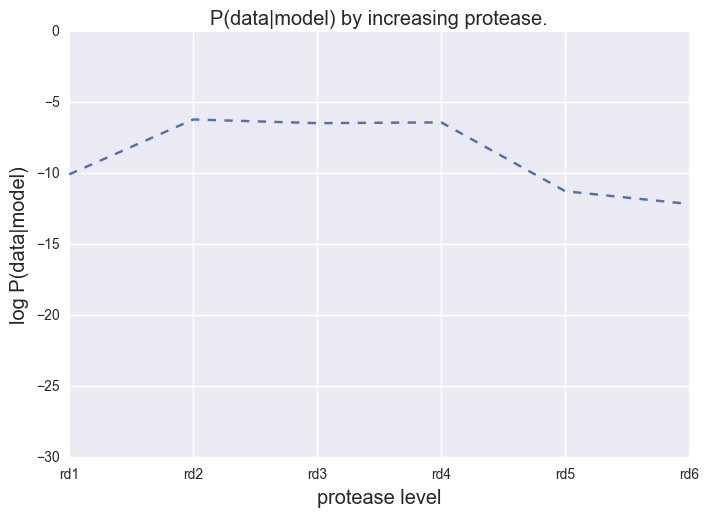

In [60]:
pylab.plot(zip(*mean_errors)[1], "--")
pylab.ylim(-30, 0)
pylab.xticks(range(len(mean_errors)), zip(*mean_errors)[0])
pylab.ylabel("log P(data|model)", fontsize="large")
pylab.xlabel("protease level", fontsize="large")
pylab.title("P(data|model) by increasing protease.", fontsize="large")

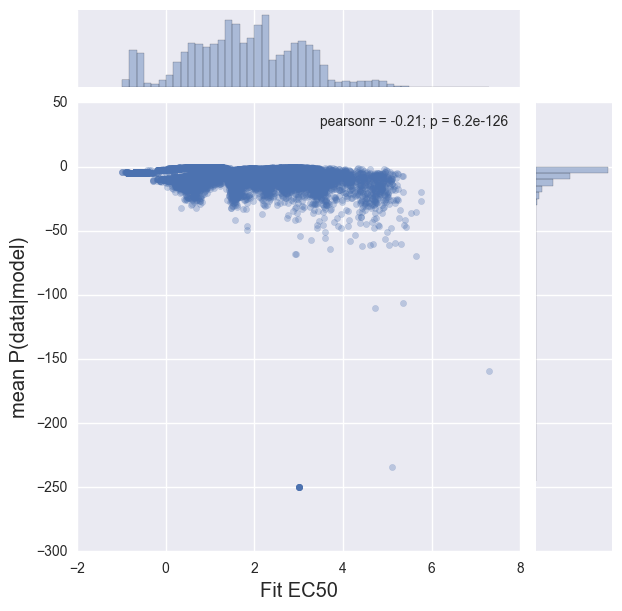

In [64]:
mean_llh = numpy.nanmean(
    numpy.stack([v["sel_log_likelihood"] for v in sel_sum.values()]),
    axis=0)
mean_llh[~numpy.isfinite(mean_llh)] = -250
jp = seaborn.jointplot( default_map["sel_ec50"], mean_llh, joint_kws={"alpha" : .3})
jp.ax_joint.set_xlabel("Fit EC50", fontsize="large")
jp.ax_joint.set_ylabel("mean P(data|model)", fontsize="large")

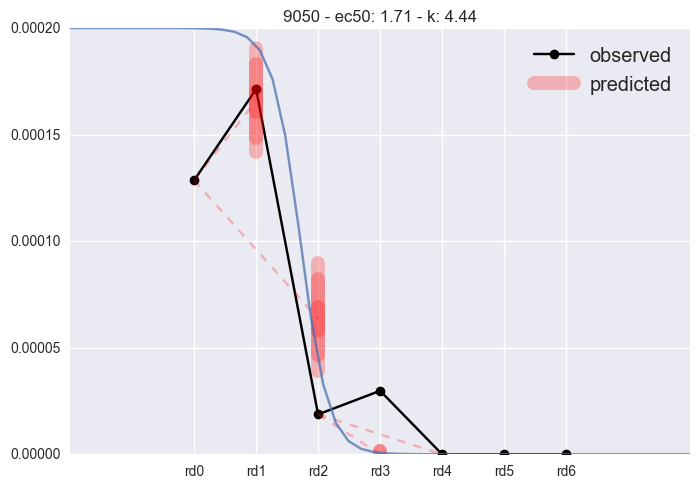

In [82]:
import scipy.stats

def plot_fit_summary(i, model, fit):
    sel_sum = model.model_selection_summary(fit)
    
    sel_levels = {
        k : p["selection_level"] if p["selection_level"] else 0
        for k, p in model.population_data.items()}
    
    sel_fracs = {
        k : p["selected"][i] / p["selected"].sum()
        for k, p in model.population_data.items()}
    
    pylab.xticks(
        sel_levels.values(), sel_levels.keys())
    pylab.xlim((-1, 7))
    
    porder = [
        k for k, p in
        sorted(model.population_data.items(), key=lambda (k, p): p["selection_level"])]
    
    pylab.plot(
        [sel_levels[k] for k in porder],
        [sel_fracs[k] for k in porder],
        "-o",
        color="black", label="observed")
    
    lbl = False
    for k in sel_sum:
        n = sel_sum[k]["selected"].sum()
        p = sel_sum[k]["pop_fraction"][i]
        sel_level = model.population_data[k]["selection_level"]
        
        if p<=0:
            continue
        
        bn = scipy.stats.binom(n=n, p=p)
        
        parkey = model.population_data[k]["parent"]
        pylab.plot(
            [sel_levels[parkey], sel_levels[k]],
            [sel_fracs[parkey], float(bn.ppf(.5)) / n],
            "--", color="red", alpha=.25
        )
        
        
        
        
        for ci in (.68, .95, .99):
            pylab.plot(
                [sel_level] * 2, bn.ppf([ci, 1-ci]) / n,
                linewidth=10, color="red", alpha=.25,
                label="predicted" if not lbl else None
            )
            lbl=True
            
    pylab.legend(fontsize="large", loc="best")
    
    pylab.twinx()
    xs = numpy.linspace(-2, 8)
    sel_ec50 = fit["sel_ec50"][i]
    sel_k = fit["sel_k"][i] if len(fit["sel_k"]) > 1 else fit["sel_k"]
    pylab.plot(xs, scipy.special.expit(-sel_k * (xs - sel_ec50)), alpha=.75)
    pylab.yticks([], [])
    
    pylab.title("%s - ec50: %.2f - k: %.2f" % (i, sel_ec50, sel_k))
    
ordering = numpy.argsort(mean_llh)

@ipywidgets.interact(i_i=ipywidgets.IntSlider(max=len(ordering) - 1))
def plot_sum(i_i):
    plot_fit_summary(ordering[i_i], chymo_model, default_map)

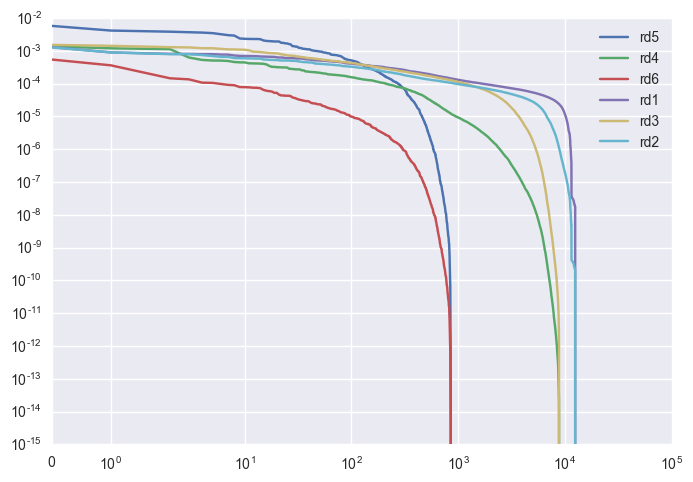

In [83]:
pylab.figure()
for k in chymo_model.model_populations:
    selection_dist = numpy.sort(chymo_model.model_populations[k]["selection_dist"](default_map))[::-1]
    pylab.plot(selection_dist, label=k)
pylab.yscale("log")
pylab.xscale("symlog")
pylab.legend()